<a href="https://colab.research.google.com/github/ivnlee/tec-mna-nlp/blob/main/semana-6-7/Equipo13_semana6y7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Modelado de Temas: LSI / LDA.



Importacion de librerias y edscarga de stopwordds antes de comenzar a desarrollar la actividad. 

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd 
import numpy as np 
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer

In [ ]:
nltk.download('stopwords')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### **1. Cargar el archivo**
Genera un DataFrame de Pandas llamado “df” y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.

In [ ]:
#Descargamos el archivo previamente almacenado en nuestro Drive de Google
dfn = pd.read_json('/content/drive/MyDrive/NLP/semana-6-7/noticiasTopicModeling.txt', lines=False, encoding='utf-8')

#Conservamos unicamente la informacion de la columna Texto
df = dfn[['texto']].copy() 

#Renombramos el nombre de la columna a noticia
df.rename(columns={'texto':'noticia'}, inplace=True)

In [ ]:
#corroboramos que df tenga los 5,658 renglones que se comentan en la actividad y visualizamos los primeros 5 elementos de df
print(df.shape)
df.head()

(5658, 1)


,noticia
0,"""España ha dejado de ser católica"", decía Manu..."
1,El clima de crispación social en Ceuta ha lleg...
2,El Gobierno ha alegado la suspensión de plazos...
3,"Puedes mandar tu pregunta, sugerencia o queja ..."
4,Panamá debe entregar esta semana a la Corte In...


###**2. Proceso de Limpieza** 
Aplica el preprocesamiento que consideres adecuado para texto en español. Recuerda que el objetivo es identificar los tokens que describan mejor la distribución de cada tema 

In [ ]:
# Obtenemos la lista de stopwords en español
stops = stopwords.words('spanish')

def clean_tok(doc):
  # Eliminamos los signos de puntuación, caracteres especiales y números
  tokens = re.sub(r'[^A-Za-záéíóúüñ\s]', ' ', doc).strip()

  # Eliminamos espacios en blanco adicionales y convierte a minúsculas
  tokens = ' '.join(re.findall(r'\b\w+\b', tokens.lower()))
  
  # Tokenizacion por palabras, elimina stopwords y palabras de longitud menor a 2
  tokens = [w for w in tokens.split() if w not in stops and len(w) > 2]

  return tokens

In [ ]:
#Almacenamos los resultados de la limpieza en una nueva variable
clean_doc = [clean_tok(x) for x in df['noticia']]

In [ ]:
#Observamos nuevamente los primeros elementos del DF preprocesado
print(clean_doc[0][0:20])

['españa', 'dejado', 'ser', 'católica', 'decía', 'manuel', 'azaña', 'comienzo', 'segunda', 'república', 'aquel', 'congreso', 'diputados', 'aprobó', 'leyes', 'laicistas', 'metáfora', 'dejó', 'ser', 'católica']


### **3. ¿Por qué en este caso no requerimos hacer una partición en entrenamiento, validación y prueba?**
Cuando trabajamos con modelos supervisados debemos de reservar un conjunto para entrenamiento y validación y otro para pruebas. El modelo se entrena con el primer conjunto y se valida su eficiencia utilizando las etiquetas dadas, una vez que estemos conformes con el rendimiento del modelo, se utiliza el conjunto de pruebas para corroborar la eficiencia del modelo. 

Sin embargo, en este caso vamos a utilizar un modelo no supervisado que va a realizar un análisis para extraer el tema y subtemas de un texto, al no haber etiquetas para corroborar, no necesitamos reservar un conjunto para pruebas, y debe de entrenarse con la mayor cantidad de información posible.

# **Parte 1: Indexación semántica latente (LSI):** 

### **4. Matriz Tf-Idf**
Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens.

In [ ]:
#Importacion de Librerias para realizar la matriz
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer 

In [ ]:
# Construimos vocabulario de palabras con base al conteo de tokens
midiccionario = Counter()

for k in range(len(clean_doc)):
  midiccionario.update(clean_doc[k])

In [ ]:
print('Longitud del diccionario:', len(midiccionario))  
print(midiccionario.most_common(10)) 

Longitud del diccionario: 100089
[('gobierno', 10326), ('años', 7545), ('dos', 7400), ('personas', 7068), ('coronavirus', 6787), ('ser', 6652), ('madrid', 6173), ('según', 6050), ('españa', 6014), ('parte', 5957)]


In [ ]:
# Convertimos cada renglón en un solo string

clean_doc = [' '.join(x) for x in clean_doc] 

In [ ]:
# Obtenemos nuestro vocabulario de tokens
vocab = list(midiccionario.keys())

# Creamos instancia de TfidfVectorizer con nuestro vocabulario
tfidfvectorizer = TfidfVectorizer(vocabulary=vocab, 
                                  norm=None,
                                  max_df=0.80,  # vamos a ignorar las palabras con frecuencia mayor a 80% suponiendo que son conectores 
                                  min_df=10,     # vamos a ignorar las palabras que aparezcan menos de 10 veces
                                  strip_accents='unicode') #Eliminamos los acentos si es que los hay (aunque leímos que unicode era más lento que ascii, también 
                                                #leímos que garantiza la remoción))

matriz_tfidf = tfidfvectorizer.fit_transform(clean_doc)

tfidf_tokens = tfidfvectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(data = matriz_tfidf.toarray(), columns = tfidf_tokens)

# Imprimimos los primeros 5 renglones
print(df_tfidf.iloc[0:5, 0:])
print(df_tfidf.shape)

   españa    dejado       ser  católica  decía    manuel  azaña  comienzo  \
0     0.0  9.529243  8.220060       0.0    0.0  6.611896    0.0  4.327796   
1     0.0  0.000000  1.644012       0.0    0.0  0.000000    0.0  0.000000   
2     0.0  0.000000  1.644012       0.0    0.0  0.000000    0.0  0.000000   
3     0.0  0.000000  4.932036       0.0    0.0  3.305948    0.0  0.000000   
4     0.0  0.000000  1.644012       0.0    0.0  0.000000    0.0  0.000000   

   segunda  república  ...  cicala  venerd  anarchici  mainl  hartmann  \
0  2.83528        0.0  ...     0.0     0.0        0.0    0.0       0.0   
1  0.00000        0.0  ...     0.0     0.0        0.0    0.0       0.0   
2  0.00000        0.0  ...     0.0     0.0        0.0    0.0       0.0   
3  0.00000        0.0  ...     0.0     0.0        0.0    0.0       0.0   
4  0.00000        0.0  ...     0.0     0.0        0.0    0.0       0.0   

   polvorientos  aqueos  iliada  rebajarla  adaya  
0           0.0     0.0     0.0        0

**¿Cuál es el significado de cada renglón?** 

Cada renglón en nuestra matriz tf-idf representa el cuerpo de una noticia, o bien, cada renglón es un documento.

**¿Y el significado de cada columna?**

Cada columna representa un token, es decir, una palabra que aparece en el cuerpo de las noticias. El número de columnas es igual al número de tokens que aparecen en todos los documentos.

### **5. Descomposición en valores singulares (SVD)**
Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.

In [ ]:
#Importamos librerias necesarias
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Definimos la cantidad de componentes 
num_comp = 10

# Descomposición SVD con 100 iteraciones
SVD = TruncatedSVD(n_components=num_comp, n_iter=100, random_state=42) 
sv_mtx = SVD.fit_transform(matriz_tfidf) 

# Obtenemos la matriz 'sigma' diagonal con los valores singulares
Sigma = SVD.singular_values_
sv_mtx.shape

(5658, 10)

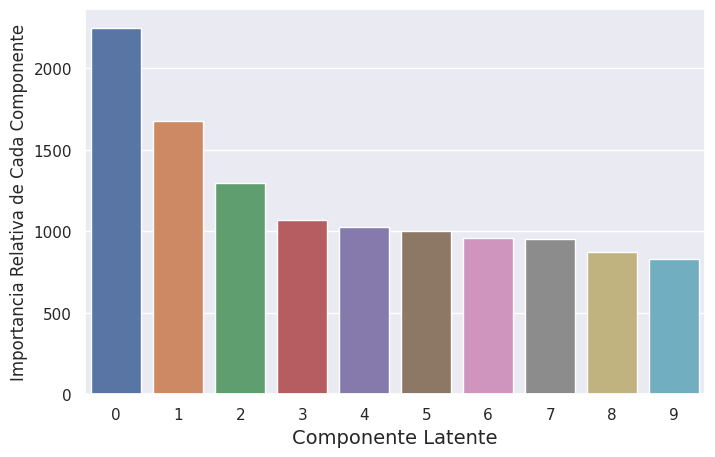

In [ ]:
# Gráfica de importancia relativa de cada componente

 # Establecer tamaño de la figura
sns.set(rc={'figure.figsize':(8, 5)})
chart = sns.barplot(x=list(range(len(Sigma))), y=Sigma)
chart.set_xlabel('Componente Latente', fontdict={'size': 14})  # Establecer etiqueta y formato del eje x
chart.set_ylabel('Importancia Relativa de Cada Componente', fontdict={'size': 12})  # Establecer etiqueta y formato del eje y
plt.show()

### **6. Obtener la matriz tokens-temas (term-topic) a partir de la matriz $𝑉^T$ de la descomposición SVD.**
Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [ ]:
# Obtener la matriz V.T
V_T = SVD.components_.T

term_topic = V_T

term_topic.shape

(100089, 10)

In [ ]:
# Obtener los nombres de los términos
term_names = list(tfidfvectorizer.get_feature_names_out())

# Construir dataframe de la matriz term-topic
term_topic_mtx = pd.DataFrame(data=term_topic, index=term_names, 
                              columns=['Concepto_Latente_'+str(i) for i in range(0, num_comp)])

print(term_topic_mtx.shape)

(100089, 10)


In [ ]:
# Imprimir los primeros 5 renglones
term_topic_mtx.head(5)

,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
españa,-1.502569e-31,1.701366e-17,-3.886196e-16,1.379603e-15,3.660463e-15,-2.279717e-15,8.077107e-17,4.806203e-15,-1.219482e-15,3.415670e-16
dejado,1.735562e-02,-2.588122e-03,-3.092085e-03,-5.085078e-03,4.106559e-03,1.657175e-04,-5.861199e-03,3.695884e-03,4.206000e-04,-9.192639e-03
ser,8.986148e-02,4.896504e-03,1.000272e-02,1.213879e-02,-1.863750e-02,-5.555311e-02,3.049787e-02,-4.821065e-03,-3.896481e-02,-1.572872e-02
católica,-1.728400e-32,8.956499e-33,7.179904e-31,2.035081e-20,-6.572709e-16,4.637150e-16,1.672890e-16,-3.497588e-16,6.624750e-17,-1.784558e-16
decía,-8.994551e-32,1.161367e-31,-1.242259e-30,-1.115739e-21,9.132708e-18,5.604316e-16,2.885396e-16,-6.968911e-17,1.084084e-16,1.186901e-16


### **7-8. Para cada uno de los 10 conceptos latentes obtenidos con la descomposición SVD, obtener el gráfico de barras que muestre los 10 términos/tokens más importantes de cada uno de ellos.**

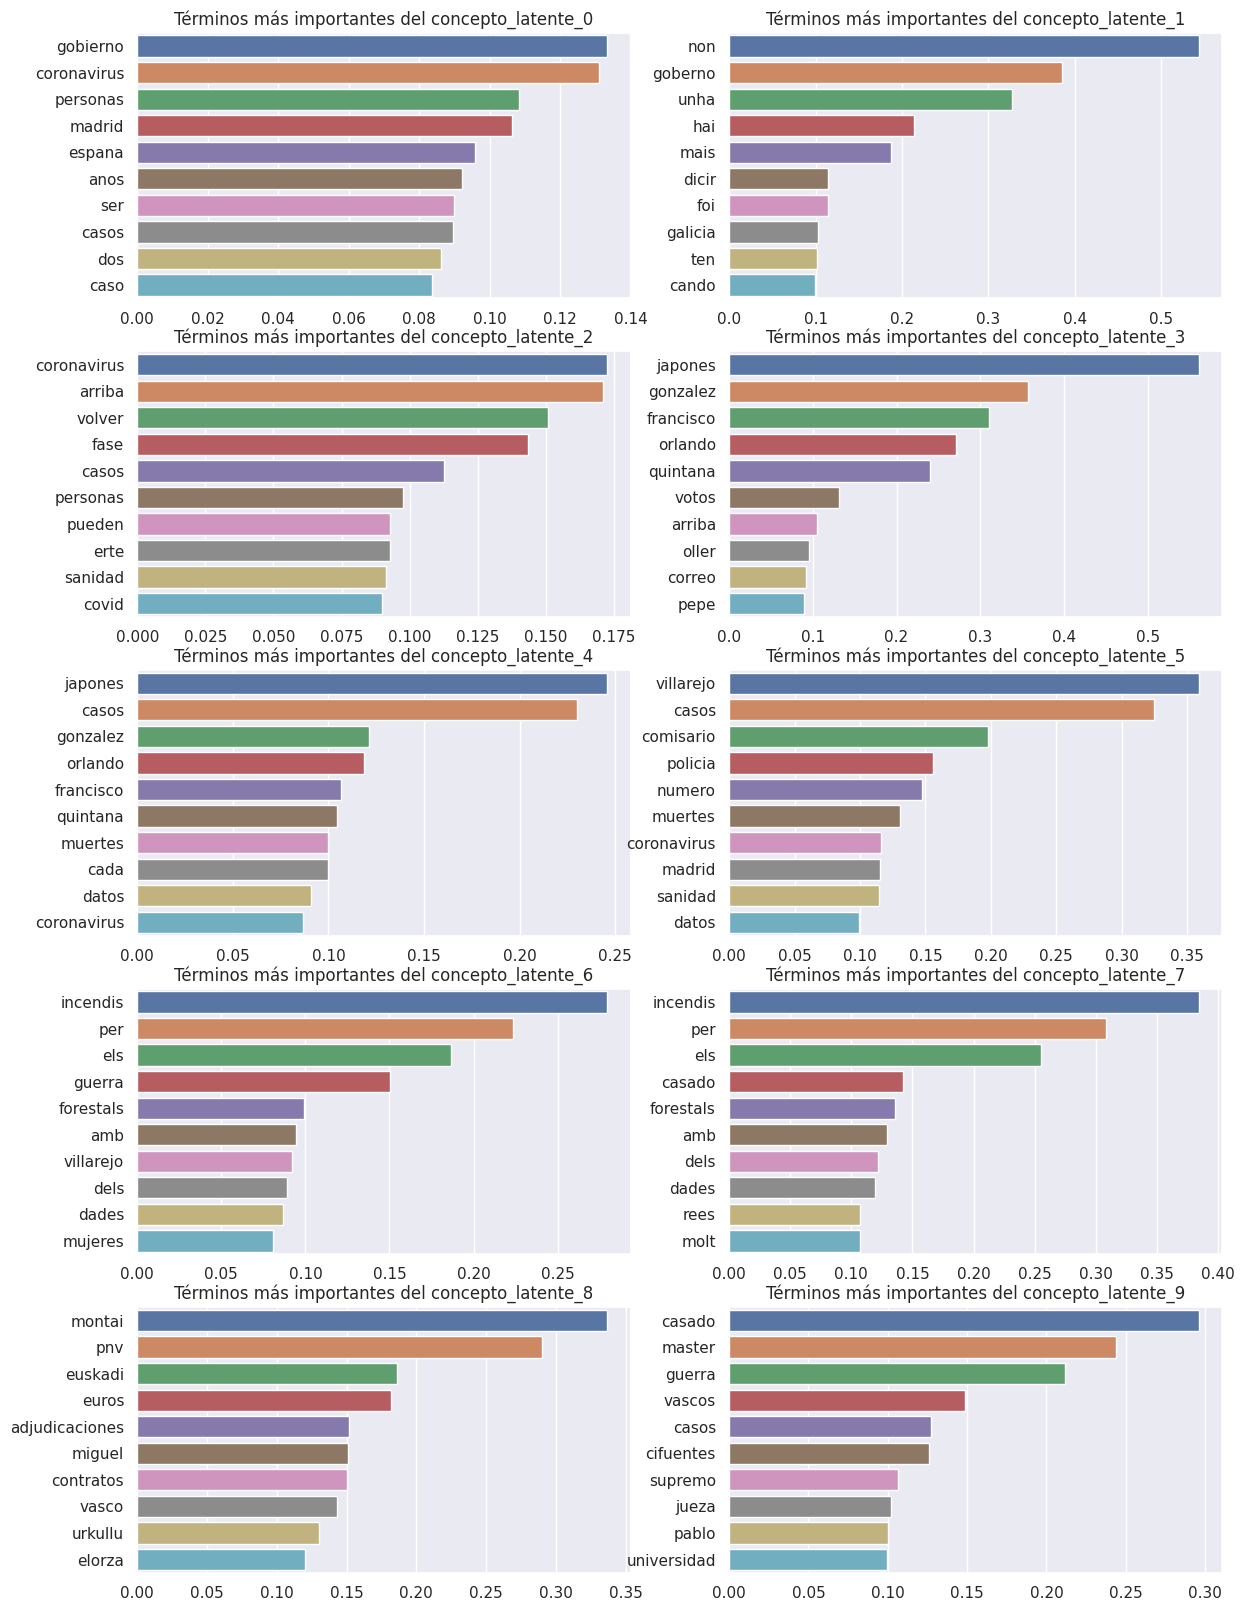

In [ ]:
#Definimos la cantidad de conceptos latentes a mostrar
top = 10

fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(14, 20))

#Impresion de terminos
for i in range(0, num_comp):
    data = term_topic_mtx['Concepto_Latente_'+str(i)].sort_values(ascending=False)
    top_term_mtx = data[:top]
    plt.subplot(5, 2, i + 1)
    plt.title('Términos más importantes del concepto_latente_'+str(i))
    ax = sns.barplot(x=top_term_mtx.values, y=top_term_mtx.index)

plt.show()

### **9. ¿Cuántos tópicos o conceptos latentes identificas con claridad? ¿Cómo los describirías, es decir, de qué temáticas estarían hablando?**

En general podríamos identificar con mas claridad 5 temas:

* El tópico o tema que se distingue con mas claridad es el de la **Pandemia**, por ejemplo, en los conceptos latentes 0 y 2 encontramos las palabras "coronavirus", "síntomas", "casos" etc..

* Otro tópico que se distingue es el de **Política** o **Gobierno**, en los conceptos latentes 1 y 7 observamos palabras como "gobierno", "partido", "ciudadanos", y "vox", "psoe" que son partidos políticos de España.

* Observamos en el componente latente 6 palabras en Catalán, en donde el tópico parece estar hablando de **Medio ambiente** con las palabras "incendis" y "forestals" (incendios y forestales en español). Aqui observamos que durante la limpieza de los datos solo eliminamos stopwords en español, por lo que para un mejor resultado podríamos considerar eliminar stopwords en catalán.

* Los componentes latentes 8 y 9 parecen estar hablando de la región del **País Vasco** en España, y mas en específico sobre conflíctos políticos ya que encontramos palabras como "guerra", "euskadi", "vasco", 
"navarros".

* Otro tema que podemos considerar en el componente 5, es el de **Crimen** o **Policiaco** aunque es un poco ambiguo ya que tambien aparece la palabra "coronavirus".

* En el caso del componente latente 4 no queda muy claro el tema principalmente debido a que los tokens principales son nombres y apellidos de personas. Vemos aquí tembién una mezcla, por ejemplo con palabras como "coronavirus" y "votos".

### **10. Modelo LSI con Gensim**
Obtener los modelos de 2 a 10 temas/tópicos y para cada uno de ellos obtener su valor (score) de coherencia.

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gensim
import gensim.corpora as corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel 

In [ ]:
# Generamos nuevamente documentos tokenizdos
docs = [clean_tok(x) for x in df['noticia']]

In [ ]:
# Creamos diccionario
mi_dicc = corpora.Dictionary(docs)

# Bolsa de palabras
bow = [mi_dicc.doc2bow(doc) for doc in docs]

In [ ]:
# Generamos modelo LSI iterando de 2 a 10 temas o clusters
for i in range(2, 11):
  lsi = LsiModel(bow, num_topics=i,
                 id2word=mi_dicc,
                 chunksize=100,
                 random_seed=42
                 )
  
  # Calculamos la métrica de coherencia para cada modelo generado
  cm = CoherenceModel(model=lsi, texts=docs,
                      dictionary=mi_dicc,
                      window_size=3,
                      coherence='c_v',
                      topn=10
                      )
  
  cs = cm.get_coherence()

  # Imprimimos la métrica de coherencia de cada modelo
  print('Métrica de Coherencia con {} clusters: {}'.format(i, cs))

Métrica de Coherencia con 2 clusters: 0.2331331198935564
Métrica de Coherencia con 3 clusters: 0.21632968253840723
Métrica de Coherencia con 4 clusters: 0.313338210122302
Métrica de Coherencia con 5 clusters: 0.3140171591952334
Métrica de Coherencia con 6 clusters: 0.3265841733968893
Métrica de Coherencia con 7 clusters: 0.2912512845319952
Métrica de Coherencia con 8 clusters: 0.30710847689882137
Métrica de Coherencia con 9 clusters: 0.3107212417202516
Métrica de Coherencia con 10 clusters: 0.33807237442803834


In [ ]:
# seleccionamos el mejor modelo
lsi = LsiModel(bow, num_topics=10,
                 id2word=mi_dicc,
                 chunksize=100,
                 random_seed=42
                 )

for topic_n, words in lsi.print_topics(num_words=10):
  print('Tokens/Palabras en Tema {}: {}.'.format(topic_n, words))

Tokens/Palabras en Tema 0: 0.216*"gobierno" + 0.161*"coronavirus" + 0.156*"personas" + 0.142*"dos" + 0.141*"años" + 0.141*"ser" + 0.132*"españa" + 0.128*"madrid" + 0.116*"caso" + 0.110*"cada".
Tokens/Palabras en Tema 1: -0.291*"casos" + -0.275*"coronavirus" + -0.182*"personas" + 0.175*"partido" + 0.165*"gobierno" + -0.148*"síntomas" + -0.131*"cada" + -0.131*"covid" + 0.120*"política" + -0.116*"sanidad".
Tokens/Palabras en Tema 2: 0.409*"casos" + 0.191*"madrid" + 0.183*"número" + 0.173*"cada" + -0.169*"volver" + 0.154*"datos" + -0.137*"arriba" + -0.133*"ser" + -0.122*"casa" + 0.117*"gobierno".
Tokens/Palabras en Tema 3: 0.387*"gobierno" + 0.279*"madrid" + -0.190*"casos" + -0.159*"años" + -0.130*"guerra" + -0.128*"mujeres" + 0.125*"partido" + 0.121*"ciudadanos" + 0.118*"sánchez" + 0.118*"ayuso".
Tokens/Palabras en Tema 4: 0.415*"non" + 0.268*"goberno" + -0.245*"villarejo" + 0.203*"unha" + 0.187*"galicia" + -0.179*"policía" + -0.135*"comisario" + 0.130*"hai" + 0.124*"país" + -0.123*"caso"

In [ ]:
# Probamos con 5 topicos
lsi = LsiModel(bow, num_topics=5,
                 id2word=mi_dicc,
                 chunksize=100,
                 random_seed=42
                 )

for topic_n, words in lsi.print_topics(num_words=10):
  print('Tokens/Palabras en Tema {}: {}.'.format(topic_n, words))

Tokens/Palabras en Tema 0: 0.217*"gobierno" + 0.160*"coronavirus" + 0.156*"personas" + 0.142*"dos" + 0.141*"ser" + 0.141*"años" + 0.132*"españa" + 0.129*"madrid" + 0.116*"caso" + 0.109*"cada".
Tokens/Palabras en Tema 1: -0.250*"coronavirus" + -0.246*"casos" + -0.187*"personas" + -0.171*"síntomas" + 0.161*"partido" + 0.157*"gobierno" + -0.133*"volver" + -0.126*"covid" + -0.122*"fase" + 0.117*"política".
Tokens/Palabras en Tema 2: 0.414*"casos" + 0.182*"madrid" + 0.181*"número" + 0.172*"cada" + 0.162*"datos" + -0.152*"casa" + -0.147*"volver" + 0.126*"gobierno" + -0.125*"arriba" + 0.115*"comunidad".
Tokens/Palabras en Tema 3: -0.540*"non" + -0.349*"goberno" + -0.264*"unha" + -0.204*"galicia" + -0.169*"hai" + -0.143*"máis" + -0.141*"país" + -0.112*"feijóo" + -0.103*"coalición" + -0.093*"creo".
Tokens/Palabras en Tema 4: 0.452*"japonés" + 0.442*"gonzález" + 0.411*"francisco" + 0.186*"votos" + 0.183*"orlando" + 0.177*"quintana" + 0.141*"partido" + 0.114*"correo" + 0.103*"dinero" + 0.092*"eur

# **Parte 2: Asignación de Dirichlet Latente (LDA)**

### **11. Utiliza la librería Gensim para implementar ahora la técnica de LDA.**
Revisa la documentación correspondiente y aplica de preferencia el modelo paralelizable.

In [ ]:
from gensim.models.ldamulticore import LdaMulticore

In [ ]:
# generamos el diccionario:

id2word = corpora.Dictionary(docs)

for id in range(5):
    print(id2word[id])

abascal
abril
actores
afd
ahora


In [ ]:
# Generamos el corpus con las tuplas (índice, frecuencia):

corpus = [id2word.doc2bow(doc) for doc in docs]

In [ ]:
# 1. Entrenamos modelo LDA paralelizable (multicore)
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10,
                                       chunksize=100,
                                       passes=10,
                                       alpha=0.5,
                                       eta=0.5
                                       )

In [ ]:
# Imprimimos los 10 temas con sus 10 principales palabras
lda_model.print_topics(num_topics=10, num_words=10)

[(0,
  '0.002*"and" + 0.001*"vitamina" + 0.001*"cardiovasculares" + 0.001*"suplementos" + 0.001*"lactobacillus" + 0.001*"azúcar" + 0.001*"omega" + 0.001*"cardiovascular" + 0.001*"cardíaca" + 0.001*"dieta"'),
 (1,
  '0.009*"millones" + 0.009*"euros" + 0.006*"empresas" + 0.005*"año" + 0.004*"empresa" + 0.004*"economía" + 0.003*"españa" + 0.003*"social" + 0.003*"según" + 0.003*"gobierno"'),
 (2,
  '0.003*"per" + 0.002*"ncia" + 0.001*"val" + 0.001*"els" + 0.001*"amb" + 0.001*"ria" + 0.001*"com" + 0.001*"més" + 0.001*"pla" + 0.001*"segur"'),
 (3,
  '0.000*"glaciar" + 0.000*"tilde" + 0.000*"basibé" + 0.000*"holter" + 0.000*"pixies" + 0.000*"zeppelin" + 0.000*"hornsby" + 0.000*"assayas" + 0.000*"fincher" + 0.000*"glaciares"'),
 (4,
  '0.021*"euskadi" + 0.014*"pnv" + 0.012*"vasco" + 0.007*"vitoria" + 0.007*"miguel" + 0.006*"urkullu" + 0.006*"osakidetza" + 0.006*"montai" + 0.005*"puedes" + 0.005*"lava"'),
 (5,
  '0.005*"años" + 0.005*"ser" + 0.004*"mujeres" + 0.003*"solo" + 0.003*"vida" + 0.003

In [ ]:
# 2. Probamos modelo LDA con 8 temas
lda_model_ = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=8,
                                       chunksize=50,
                                       passes=10,
                                       alpha=0.5,
                                       eta=0.5
                                       )

In [ ]:
lda_model_.print_topics(num_topics=8, num_words=10)

[(0,
  '0.007*"caso" + 0.005*"euros" + 0.005*"dos" + 0.005*"policía" + 0.004*"investigación" + 0.004*"según" + 0.003*"años" + 0.003*"eldiario" + 0.003*"tribunal" + 0.003*"juez"'),
 (1,
  '0.015*"gobierno" + 0.007*"podemos" + 0.006*"partido" + 0.006*"política" + 0.004*"presidente" + 0.004*"ciudadanos" + 0.004*"sánchez" + 0.004*"acuerdo" + 0.004*"psoe" + 0.003*"comisión"'),
 (2,
  '0.007*"coronavirus" + 0.006*"personas" + 0.005*"casos" + 0.004*"madrid" + 0.004*"españa" + 0.004*"crisis" + 0.004*"millones" + 0.004*"medidas" + 0.004*"cada" + 0.004*"días"'),
 (3,
  '0.005*"años" + 0.004*"ser" + 0.003*"historia" + 0.003*"vida" + 0.003*"solo" + 0.003*"mujeres" + 0.003*"mundo" + 0.003*"dos" + 0.003*"cómo" + 0.003*"puede"'),
 (4,
  '0.005*"guerra" + 0.004*"unidos" + 0.004*"trump" + 0.004*"país" + 0.003*"efe" + 0.003*"eeuu" + 0.003*"internacional" + 0.003*"dólares" + 0.003*"norte" + 0.003*"dijo"')]

### **12. ¿Qué cantidad de tópicos consideras que es la más adecuada?**
El análisis con el método LDA nos da términos mas claros para cada tema, podemos considerar los siguientes:

| Tema # | Tópico |
| :---   | :------ |
| Tema 0 | Pandemia |
| Tema 1 | Noticias Internacionales |
| Tema 2 | Pandemia en Madrid |
| Tema 3 | Repercusiones Economicas |
| Tema 4 | Política |
| Tema 5 | Alimentación/Salud |
| Tema 6 | Medio ambiente |
| Tema 7 | Arte/Cultura |
| Tema 8 | Economía |
| Tema 9 | Noticias Locales |

### **Compara tus resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias?**

Ambos modelos coincidieron al encontrar 4 temas principales dentro del corpus como lo son:


1.   Pandemia
2.   Politica
3.   Noticias Internacionales
4.   Cultura

Algunos de los conceptos latentes dentro de cada topico tambien llegaron a coincidir dentro de estos principales temas, sin embargo, en la prueba base buscando los 10 temas la diferencia entre ambos modelos era mayor.


### **¿Cuál consideras puede ser la mejor cantidad de tópicos a considerar?**
Al cada modelo tener metodologias diferentes deberiamos considerar una cantidad de topicos para cada uno, de acuerdo a las pruebas realizadas para LSI la mejor cantidad de topicos era 5 mientras que LDA conseguia su mejor rendimiento con 8 topicos.

Promediando y considerando la similitud de conceptos latentes entre ambos modelos,podriamos generalizar el uso de 6 topicos para ambos, si lo que se quiere es comparar la misma cantidad de "n_topics".


### **13. La librería pyLDAvis nos ayuda a visualizar de manera interactiva los temas y tokens de los documentos analizados. Revisa la documentación y utilízala para visualizar tu mejor resultado.**

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

In [ ]:
# habilitamos el notebook para desplegar la visualización
pyLDAvis.enable_notebook()

# Generamos la visualización de nuestro modelo
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=10, n_jobs=1)
# desplegamos la visualización
pyLDAvis.display(vis)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


### **14. Conclusión final**
A pesar de que los resultados encontrados en ambos modelos fueron bastante parecidos en temas principales, los "subtemas" o los que tenian una menor cantidad de palabras determinantes dieron resultados muy diferentes.

Para esta actividad podriamos concluir que el modelo de Dirichlet tuvo mejores resultados, pues fue mas sencillo determinar los topicos ya que las conceptos latentes eran mas significativos. Ademas que el modelo LSI creo un par de topicos con casi los mismos conceptos latentes a diferenciacion de palabras minimas, pareciendo como si fue mas complicado encontrar los subtemas o palabras de valor que definieran los topicos (vease abajo).

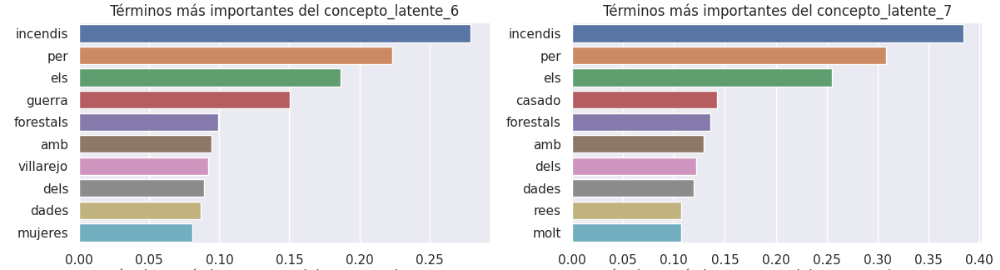

Aun asi no descartamos que las dificultadas presentados en LSI sean resultado del procesamiento de datos, pues dentro del corpus existian palabras en un idioma diferente asi como el uso de nombres propios de partidos politicos, esto tambien puede ser resultado de que el modelo utiliza como base la matriz TFIDF mientras que el modelo de Dirchilet pudo resolverlo mejor agrupando las palabras en otro idioma y la mayoria de nombres propios en respectivos topicos gracias a que esta basado en un modelo probabilistico.

Una forma en la que intentamos balancear los modelos fue añadiendo al pre-procesamiento los pasos de lemmatizacion y exclusion de palabras en otro idioma, sin embargo, los resultados no fueron los esperados. Recordando la teoria previamente expuesta en clase recordamos que tanto para LDA y LSI la Lematizacion puede ser perjudicial, pues son modelos que consideran las palabras contiguas al toquen para obtener el coeficiente de coherencia y al modificar estas palabras el contexto se veia afectando generando peores resultados.

### Screenshots de la visualización del ejercicio 13 librería **pyLDAvis**

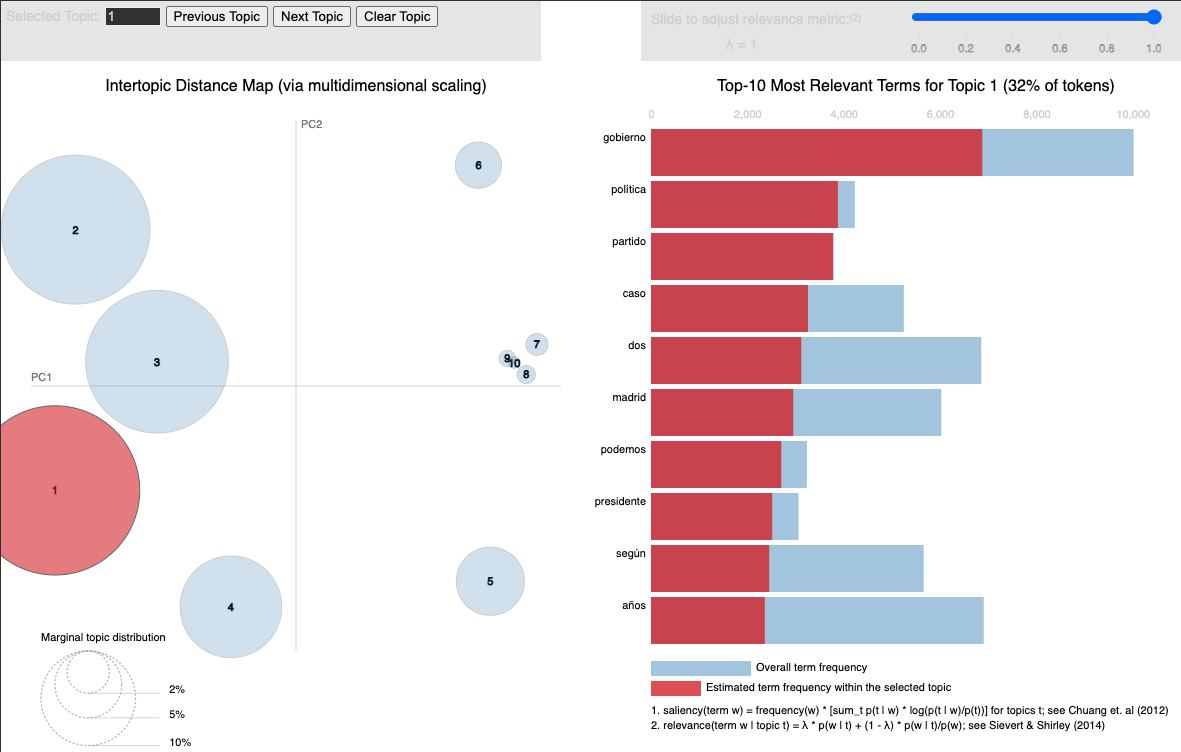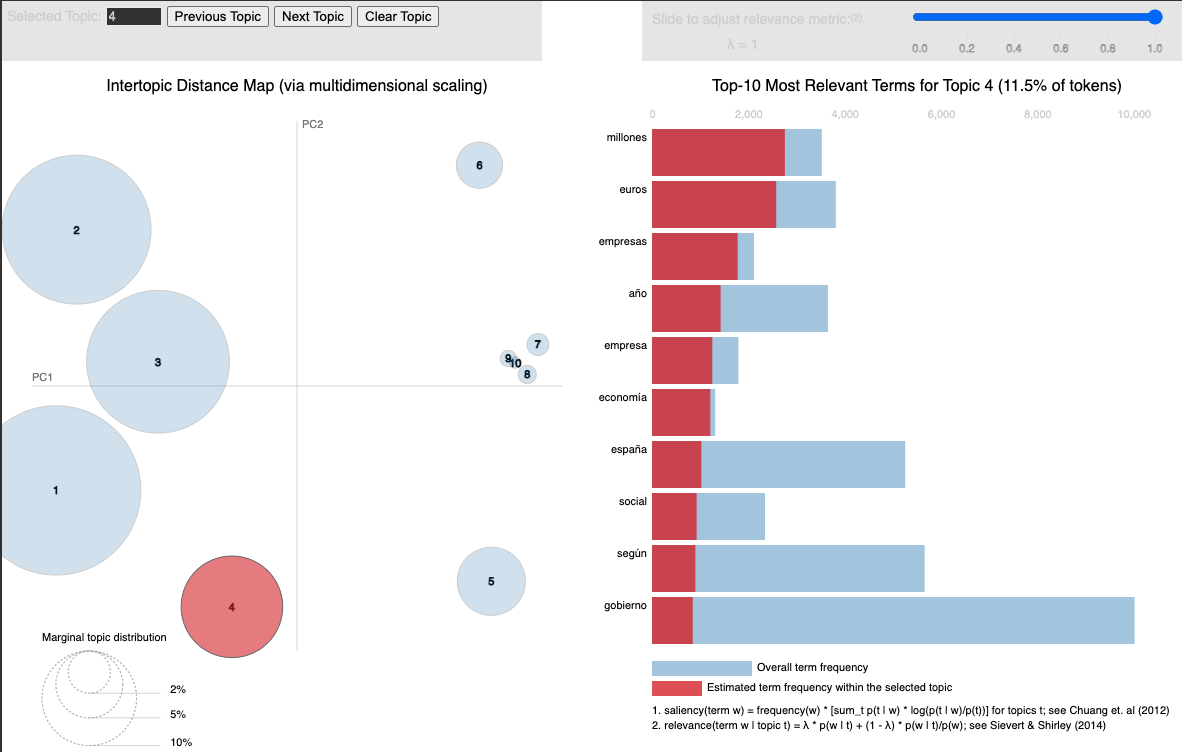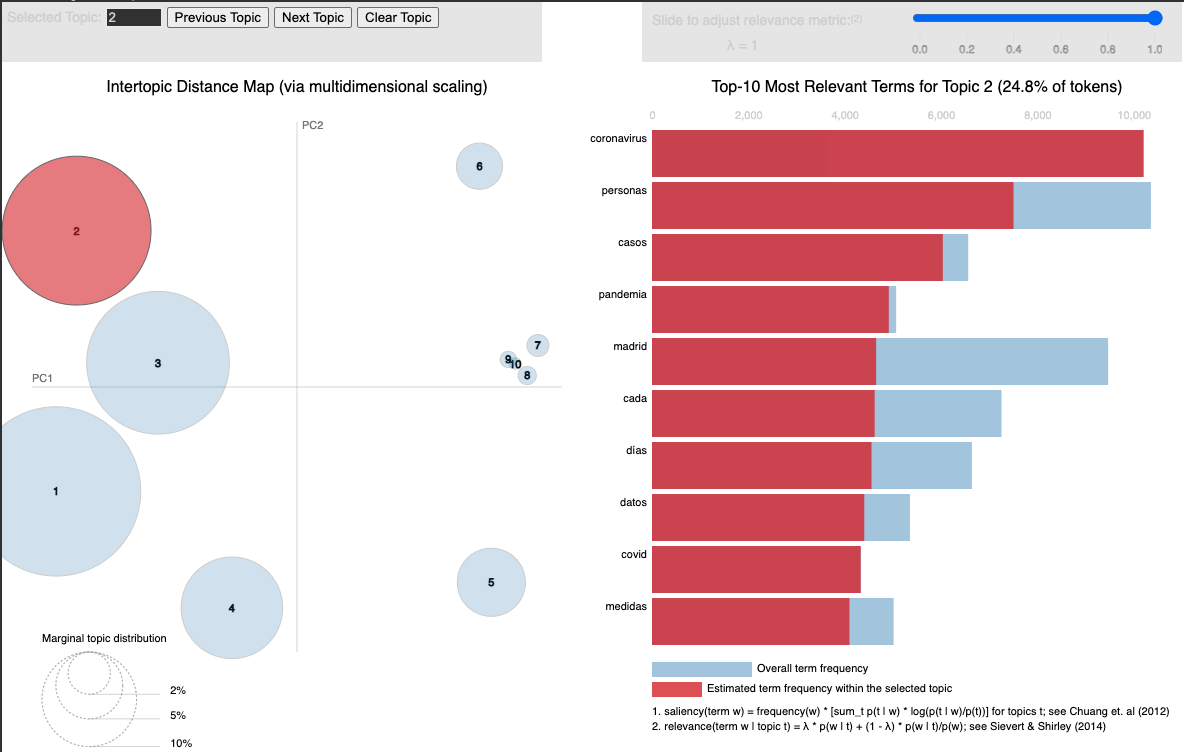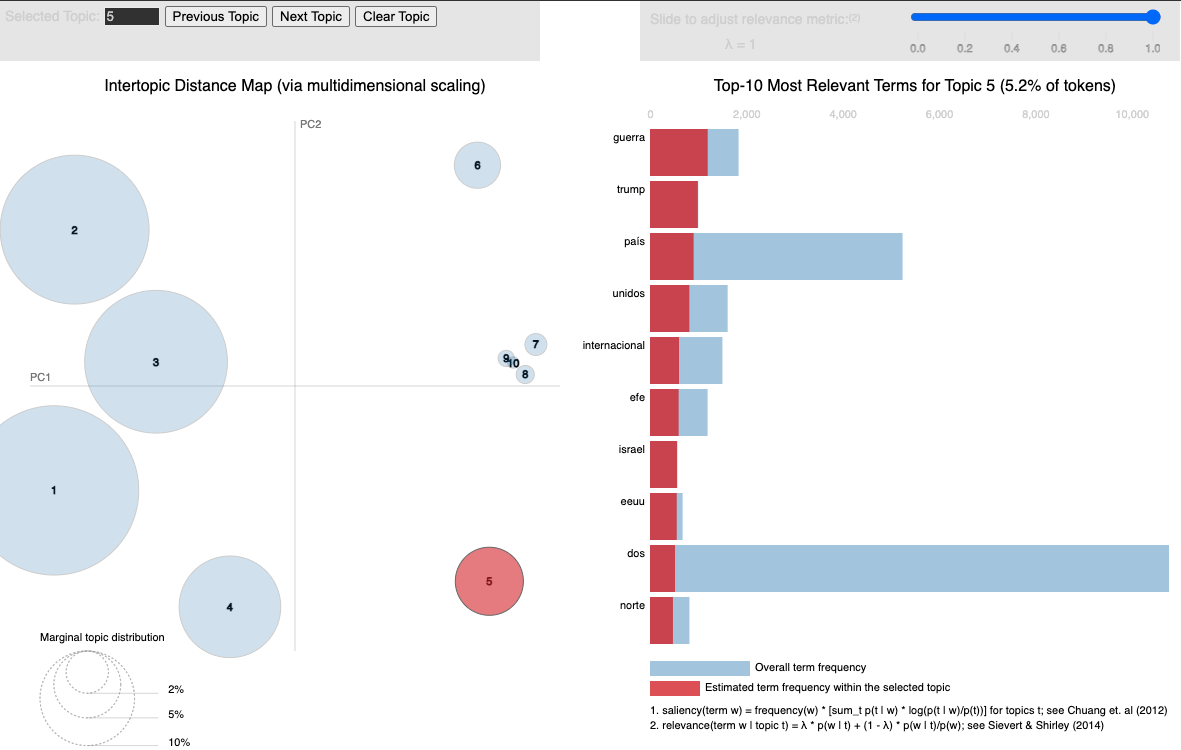